In [1]:
!pip install kagglehub scikit-learn numpy pandas matplotlib seaborn


In [2]:
import os
import math
import abc

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.model_selection
import sklearn.neighbors
import sklearn.preprocessing
import sklearn.metrics

import kagglehub

import collections


# 1. Выбор начальных условий

Для задачи регрессии мною был выбран датасет с Kaggle для оценки стоимости поездки на такси на основе условий.

Ниже приведено подробное описание каждого столбца в наборе данных:

- Distance (in kilometers): The length of the trip.
- Pickup Time: The starting time of the trip.
- Dropoff Time: The ending time of the trip.
- Traffic Condition: Categorical indicator of traffic (light, medium, heavy).
- Passenger Count: Number of passengers for the trip.
- Weather Condition: Categorical data for weather (clear, rain, snow).
- Trip Duration (in minutes): Total trip time.
- Fare Amount (target): The cost of the trip (in USD).
- Dataset Highlights




Скачаем датасет, загрузим его в память и провизуализируем его краткое содержание



In [32]:
# Download latest version
path = kagglehub.dataset_download("denkuznetz/taxi-price-prediction")
ds = pd.read_csv(os.path.join(path, 'taxi_trip_pricing.csv'))

ds.head()

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,47.59,Afternoon,Weekday,1.0,High,Clear,NaN,0.62,0.43,40.57,NaN
2,36.87,Evening,Weekend,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,Weekday,4.0,Low,NaN,3.48,0.51,0.15,116.81,36.4698
4,NaN,Evening,Weekday,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180


# Выбор метрик
Для задачи регрессии были выбраны следующие метрики:

MAE (Средняя абсолютная ошибка) — эта метрика предоставляет интуитивно понятное представление о величине ошибки в тех же единицах измерения, что и целевая переменная. В данном случае MAE покажет, на сколько в денежном выражении модель ошибается, сравнивая предсказанную и реальную стоимость поездки. Это позволит оценить ошибки модели с точки зрения финансов.

R-square (Коэффициент детерминации) — эта метрика показывает, какую долю дисперсии целевой переменной объясняет модель. Она поможет оценить, насколько хорошо модель описывает данные, выявить важные признаки в датасете и понять, насколько точно модель подогнана под данные.



# 2. Создание бейзлайна и оценка качества
Основная цель бейзлайна — разработать простую начальную модель, которая будет служить отправной точкой для последующих улучшений.

Для этого проведем минимальную подготовку данных, чтобы они стали пригодными для обучения модели. На первом этапе проверим, есть ли в датасете пропущенные значения.


In [33]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       950 non-null    float64
 1   Time_of_Day            950 non-null    object 
 2   Day_of_Week            950 non-null    object 
 3   Passenger_Count        950 non-null    float64
 4   Traffic_Conditions     950 non-null    object 
 5   Weather                950 non-null    object 
 6   Base_Fare              950 non-null    float64
 7   Per_Km_Rate            950 non-null    float64
 8   Per_Minute_Rate        950 non-null    float64
 9   Trip_Duration_Minutes  950 non-null    float64
 10  Trip_Price             951 non-null    float64
dtypes: float64(7), object(4)
memory usage: 86.1+ KB


Как видно, в датасете присутствуют пропущенные значения во всех признаках, включая целевую переменную — стоимость поездки. Кроме того, стоит отметить, что некоторые признаки являются категориальными, а другие — числовыми.

Для обработки данных предлагается следующая стратегия:

Удалить записи, в которых отсутствуют значения целевой переменной (стоимость поездки), поскольку это ключевая цель модели. Заполнение этих пропусков (например, с использованием медианного значения) не имеет смысла и может негативно повлиять на точность предсказаний.

Для категориальных признаков оставить пропущенные значения, так как при применении one-hot encoding такие пропуски будут преобразованы в векторы, содержащие нули: [0, ..., 0].

Для числовых признаков заменить пропущенные значения на медиану, чтобы минимизировать влияние выбросов и сохранить основные характеристики данных.




In [34]:
baseline_ds = ds.dropna(subset=["Trip_Price"])

numeric_features = [
  "Trip_Distance_km",
  "Passenger_Count",
  "Base_Fare",
  "Per_Km_Rate",
  "Per_Minute_Rate",
  "Trip_Duration_Minutes",
]
baseline_ds[numeric_features] = baseline_ds[numeric_features].apply(lambda col: col.fillna(col.median()))

categorical_features = [
  "Time_of_Day",
  "Day_of_Week",
  "Traffic_Conditions",
  "Weather",
]

for feature in categorical_features:
  encoded_feature = pd.get_dummies(baseline_ds[feature], prefix=feature, dtype=int)
  baseline_ds[encoded_feature.columns] = encoded_feature
  baseline_ds = baseline_ds.drop(columns=[feature])

baseline_ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 951 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Trip_Distance_km           951 non-null    float64
 1   Passenger_Count            951 non-null    float64
 2   Base_Fare                  951 non-null    float64
 3   Per_Km_Rate                951 non-null    float64
 4   Per_Minute_Rate            951 non-null    float64
 5   Trip_Duration_Minutes      951 non-null    float64
 6   Trip_Price                 951 non-null    float64
 7   Time_of_Day_Afternoon      951 non-null    int64  
 8   Time_of_Day_Evening        951 non-null    int64  
 9   Time_of_Day_Morning        951 non-null    int64  
 10  Time_of_Day_Night          951 non-null    int64  
 11  Day_of_Week_Weekday        951 non-null    int64  
 12  Day_of_Week_Weekend        951 non-null    int64  
 13  Traffic_Conditions_High    951 non-null    int64  
 14 

<ipython-input-34-2a964789e230>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_ds[numeric_features] = baseline_ds[numeric_features].apply(lambda col: col.fillna(col.median()))
<ipython-input-34-2a964789e230>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_ds[encoded_feature.columns] = encoded_feature
<ipython-input-34-2a964789e230>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

Теперь перейдем к этапу обучения модели. Аналогично разделу, посвященному решению задачи классификации, определим вспомогательные функции:

- `generate_train_data` — отвечает за создание обучающего и тестового набора данных на основе предоставленного датасета.  
- `get_model_metrics` — предназначена для расчета метрик производительности модели, используя тестовые данные.  
- `print_model_metrics` — выполняет форматированный вывод рассчитанных метрик.

In [35]:
def generate_train_data(dataset, *, target_feature="Trip_Price", test_size=0.2, random_state=42):
  X = dataset.drop(columns=[target_feature])
  y = dataset[target_feature]
  X_train, X_test, y_train, y_test = map(
    np.array,
    sklearn.model_selection.train_test_split(
      X, y,
      test_size=test_size,
      random_state=random_state,
    ),
  )

  return (X_train, y_train), (X_test, y_test)


def get_model_metrics(model, X_test, y_test):
  y_pred = model.predict(X_test)

  mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
  r2 = sklearn.metrics.r2_score(y_test, y_pred)

  return { "mae": mae, "r2": r2 }


def print_model_metrics(model, X_test, y_test):
  results = get_model_metrics(model, X_test, y_test)

  print(f"Mean Absolute Error (MAE): {results['mae']:.4f}")
  print(f"R-squared (R2): {results['r2']:.4f}")


Обучим теперь модель KNN для решения задачи регрессии на бейзлайн-датасете, который мы ранее определили и выведем на экран показатели метрик для итоговой обученной модели.




In [36]:
(X_train, y_train), (X_test, y_test) = generate_train_data(baseline_ds)

model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=4)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)


Mean Absolute Error (MAE): 14.2187
R-squared (R2): 0.8532


### Выводы  
На основании полученных метрик можно сделать следующие заключения:  

1. Во-первых, модель успешно выявляет ключевые зависимости в данных, что подтверждается значениями метрики R2, которые близки к 2.  

2. Во-вторых, средняя ошибка модели составляет 14 денежных единиц. Этот уровень ошибки является приемлемым для поездок с высокой стоимостью, но может быть слишком значительным для поездок с низкой ценой.  

Таким образом, рекомендуется доработать базовую модель, чтобы снизить значение метрики MAE, одновременно стремясь сохранить текущие высокие показатели R2.

# 3. Улучшение бейзлайна

## Устранение мультиколлинеарности  
Оптимизацию базовой модели целесообразно начать с устранения проблемы мультиколлинеарности, которая часто возникает в наборах данных с большим числом признаков.  

Мультиколлинеарность возникает, когда два или более признаков демонстрируют сильную корреляцию между собой. В таких случаях один из признаков теряет информативность, поскольку может быть выражен через другие.  

Для некоторых моделей наличие таких признаков может стать препятствием, так как они приводят к нестабильности в процессе обучения.  

Чтобы выявить признаки, подверженные мультиколлинеарности, создадим и проанализируем корреляционную матрицу.  

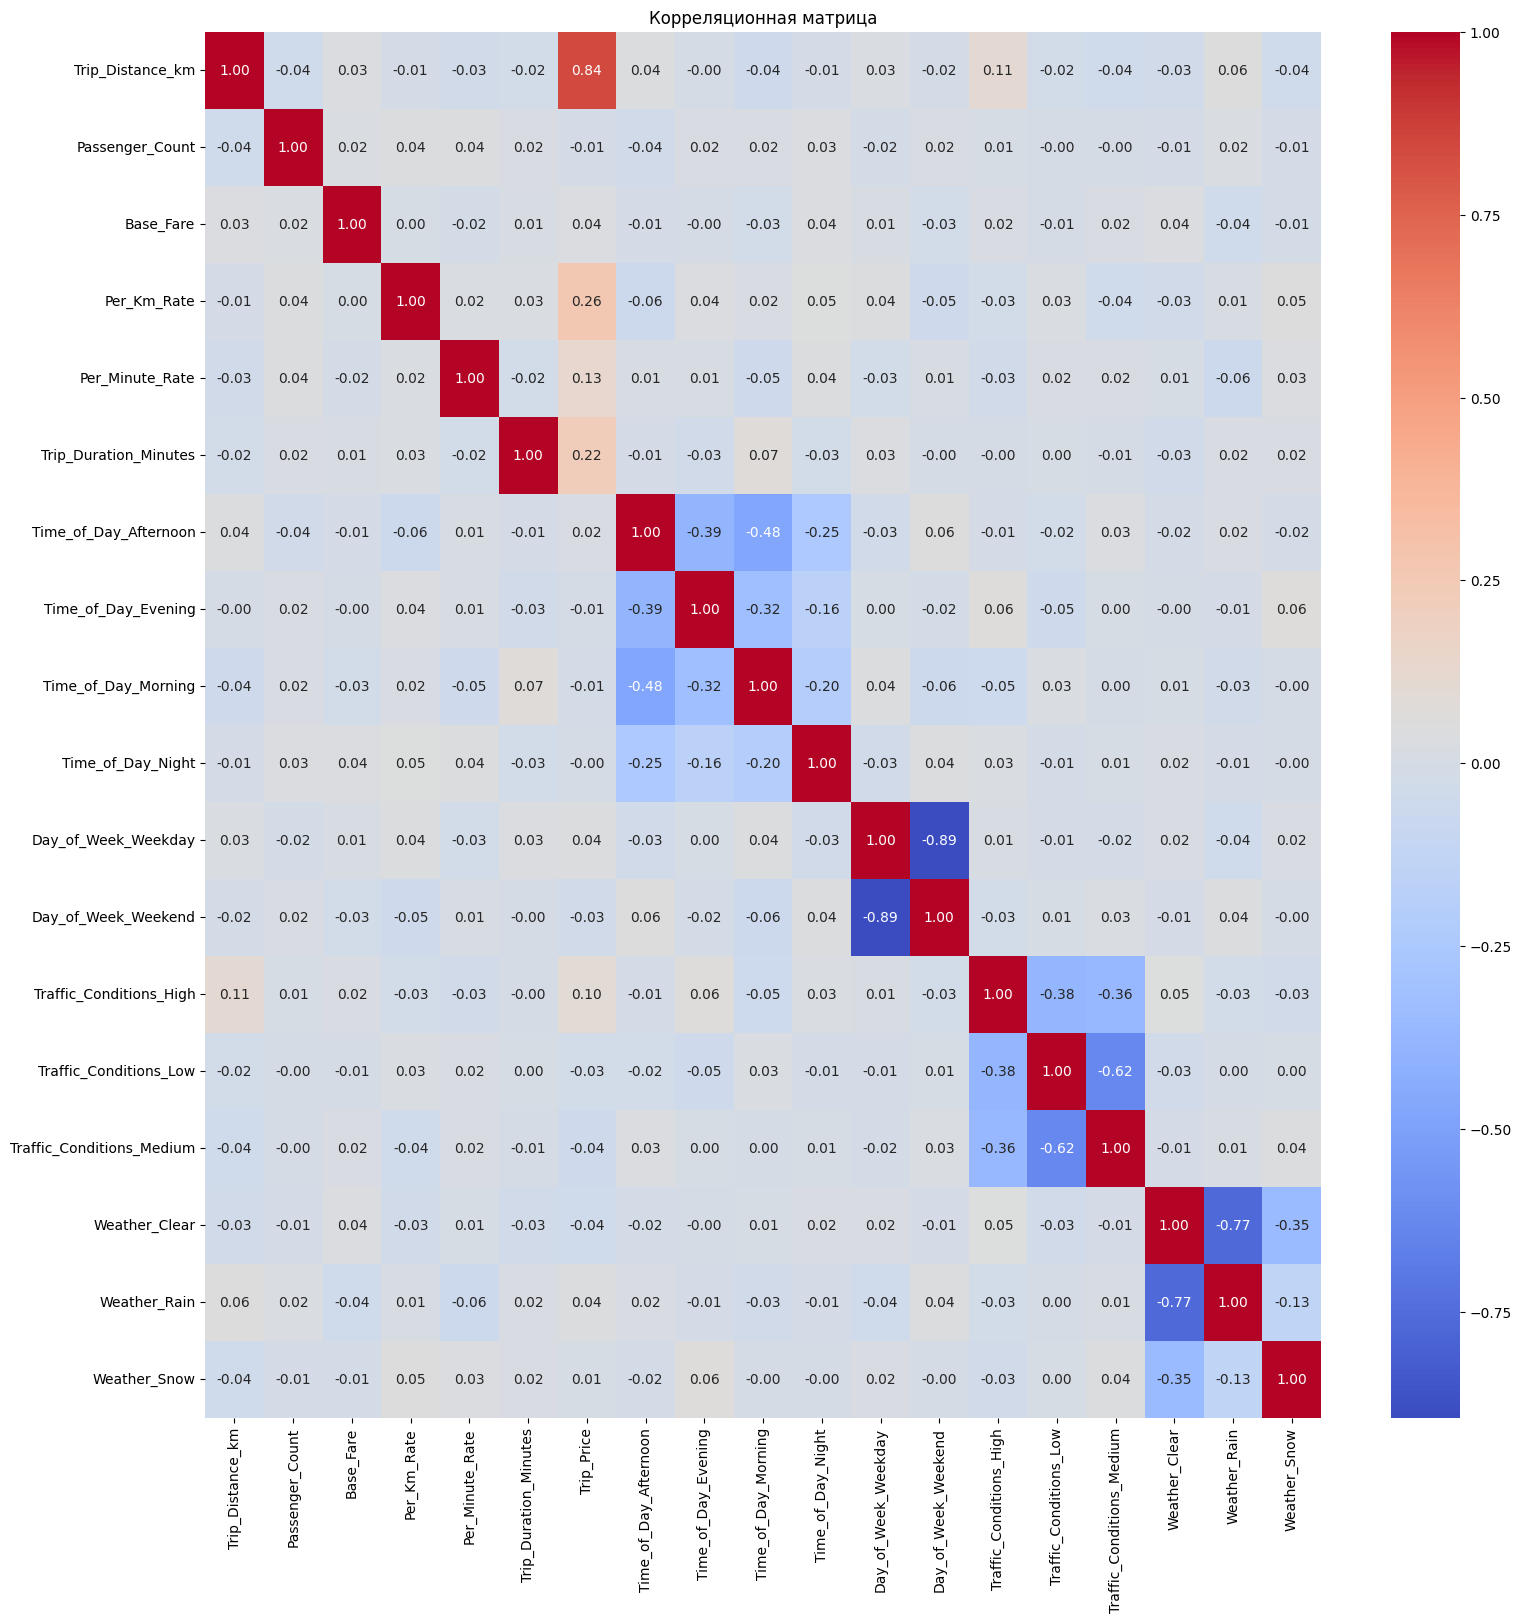

In [37]:
corr_matrix = baseline_ds.corr().drop("Trip_Price", axis=0)

plt.figure(figsize=(18, 18))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляционная матрица")
plt.show()


Как видим, проблема мультиколлинеарности свойственна для категориальных признаков, таких как "Тип дня недели", "Время суток", "Условия трафика", "Погода".

Решим найденную проблему путем сведения признаков, которые были созданы через one-hot encoding к одному признаку с использованием порядкого кодирования. Такой способ также будет иметь смысл в контексте KNN алгоритма, так как между значениями теперь можно ввести понятие "расстояния".


In [38]:
def convert_one_hot_to_single_column(dataset, new_column, one_hot_columns):
  dataset[new_column] = sum(w * dataset[col] for w, col in enumerate(one_hot_columns, 1))
  dataset.drop(columns=one_hot_columns, inplace=True)


optimized_ds = baseline_ds.copy()

convert_one_hot_to_single_column(
  dataset=optimized_ds,
  new_column="Day_of_Week",
  one_hot_columns=["Day_of_Week_Weekday", "Day_of_Week_Weekend"],
)

convert_one_hot_to_single_column(
  dataset=optimized_ds,
  new_column="Time_of_Day",
  one_hot_columns=["Time_of_Day_Morning", "Time_of_Day_Afternoon", "Time_of_Day_Evening", "Time_of_Day_Night"],
)

convert_one_hot_to_single_column(
  dataset=optimized_ds,
  new_column="Traffic_Conditions",
  one_hot_columns=["Traffic_Conditions_Low", "Traffic_Conditions_Medium", "Traffic_Conditions_High"],
)

convert_one_hot_to_single_column(
  dataset=optimized_ds,
  new_column="Weather",
  one_hot_columns=["Weather_Clear", "Weather_Rain", "Weather_Snow"],
)

optimized_ds.head()

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price,Day_of_Week,Time_of_Day,Traffic_Conditions,Weather
0,19.35,3.0,3.56,0.80,0.32,53.82,36.2624,1,1,1,1
2,36.87,1.0,2.70,1.21,0.15,37.27,52.9032,2,3,3,1
3,30.33,4.0,3.48,0.51,0.15,116.81,36.4698,1,3,1,0
4,25.87,3.0,2.93,0.63,0.32,22.64,15.6180,1,3,3,1
5,8.64,2.0,2.55,1.71,0.48,89.33,60.2028,2,2,2,1


In [39]:
(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds)

model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=4)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 14.3450
R-squared (R2): 0.8503


# Нормализация и масштабирование признаков  

При доработке базовой модели важно учитывать особенности алгоритма KNN. Этот метод рассматривает значения признаков как координаты точек, используемые для вычисления метрики расстояния.  

Таким образом, KNN оказывается крайне чувствительным к масштабу данных. Поэтому целесообразно выполнить нормализацию признаков.  

Прежде чем приступать к нормализации, необходимо оценить, присутствует ли в текущем наборе данных проблема различающихся диапазонов значений.


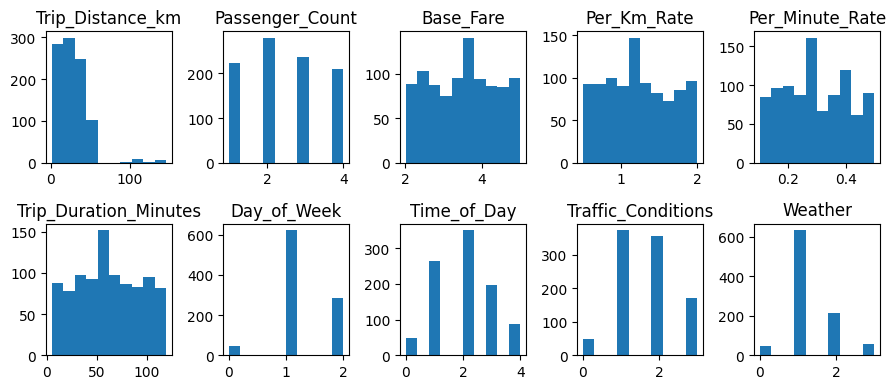

In [40]:
numerical_features = [
  "Trip_Distance_km",
  "Passenger_Count",
  "Base_Fare",
  "Per_Km_Rate",
  "Per_Minute_Rate",
  "Trip_Duration_Minutes",
  "Day_of_Week",
  "Time_of_Day",
  "Traffic_Conditions",
  "Weather",
]
n = len(numerical_features)

cols = 5
rows = math.ceil(len(numerical_features) / cols)

def print_histograms(dataset):
  plt.figure(figsize=(9, rows * 2))

  for i, feature in enumerate(numerical_features, 1):
    plt.subplot(rows, cols, i)
    plt.hist(dataset[feature])
    plt.title(feature)
    plt.tight_layout()

  plt.show()

print_histograms(optimized_ds)

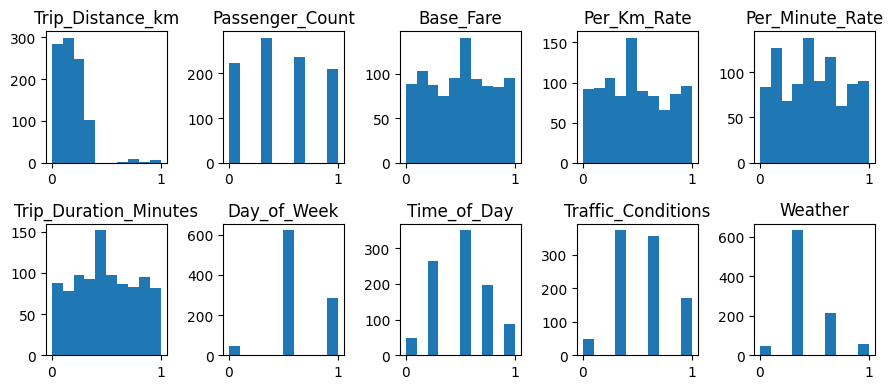

In [41]:
scaled_ds = optimized_ds.copy()
scaler = sklearn.preprocessing.MinMaxScaler()
scaled_ds[numerical_features] = scaler.fit_transform(scaled_ds[numerical_features])

print_histograms(scaled_ds)

In [42]:
(X_train, y_train), (X_test, y_test) = generate_train_data(scaled_ds)

model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=4)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 19.3130
R-squared (R2): 0.4930


Как можно заметить, после нормализации показатели метрик значительно снизились. Это связано с тем, что нормализация уравняла веса всех признаков, тогда как до её применения некоторые признаки имели большее влияние.  

Тем не менее, этот шаг является важным подготовительным этапом для проверки следующей гипотезы.

### Настройка весов признаков  

После нормализации все признаки получили равный вклад в расчет метрики расстояния. Однако теперь мы можем самостоятельно задать веса для каждого признака.  

Весовые коэффициенты предлагается определить на основе корреляции: признаки с более высокой степенью корреляции с целевой переменной будут иметь больший вес.


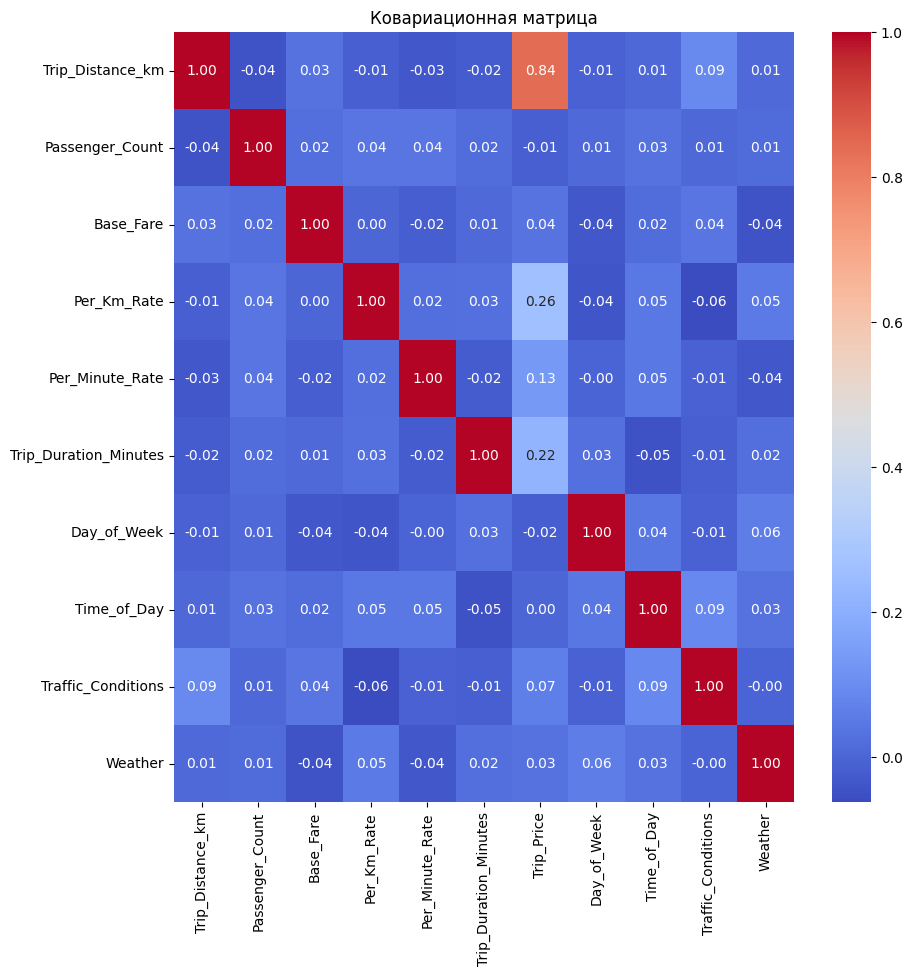

In [43]:
corr_matrix = scaled_ds.corr().drop("Trip_Price", axis=0)

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Ковариационная матрица")
plt.show()

In [44]:

correlations = corr_matrix["Trip_Price"]
k = abs(correlations).max()

weights = abs(correlations) / k
weights["Trip_Price"] = 1.0

weighted_ds = scaled_ds * weights
weighted_ds.head()

,Base_Fare,Day_of_Week,Passenger_Count,Per_Km_Rate,Per_Minute_Rate,Time_of_Day,Traffic_Conditions,Trip_Distance_km,Trip_Duration_Minutes,Trip_Price,Weather
0,0.021652,0.010213,0.010431,0.062603,0.087490,0.000260,0.026060,0.125106,0.110772,36.2624,0.011594
2,0.009639,0.020426,0.000000,0.148159,0.019884,0.000779,0.078179,0.246070,0.073213,52.9032,0.011594
3,0.020535,0.010213,0.015647,0.002087,0.019884,0.000779,0.026060,0.200915,0.253726,36.4698,0.000000
4,0.012852,0.010213,0.010431,0.027128,0.087490,0.000779,0.078179,0.170122,0.040011,15.6180,0.011594
5,0.007543,0.020426,0.005216,0.252497,0.151118,0.000519,0.052119,0.051161,0.191361,60.2028,0.011594


In [45]:
(X_train, y_train), (X_test, y_test) = generate_train_data(weighted_ds)

model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=4)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)


Mean Absolute Error (MAE): 5.6710
R-squared (R2): 0.9585


Как можно заметить, показатели метрик значительно улучшились, превзойдя даже те, что были получены до нормализации данных. Это подтверждает правильность выдвинутой гипотезы.





### 4. Реализация алгоритма машинного обучения  

Теперь перейдем к собственной реализации алгоритма KNN для решения задачи классификации. Моё решение оформлено в виде класса `MyKNNRegressor`, чей интерфейс напоминает стандартный подход, используемый в библиотеке sklearn.  

Класс включает два метода:  
- `fit` — для обучения модели на предоставленных данных.  
- `predict` — для предсказания классов на основе обученной модели.  

Метрика расстояния реализована в виде функций, принимающих на вход два массива объектов и вычисляющих попарные расстояния между ними.

In [46]:
import numpy as np
from collections import Counter

class KNN:
    def __init__(self, n_neighbors=3, task='regression'):
        self.n_neighbors = n_neighbors
        self.task = task

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def predict(self, X):
        X = np.array(X)
        predictions = []
        for x in X:
            distances = [self._euclidean_distance(x, x_train_dist) for x_train_dist in self.X_train]
            k_indices = np.argsort(distances)[:self.n_neighbors]
            k_nearest_values = [self.y_train[i] for i in k_indices]

            if self.task == 'classification':
                most_common = Counter(k_nearest_values).most_common(1)
                predictions.append(most_common[0][0])
            elif self.task == 'regression':
                predictions.append(np.mean(k_nearest_values))
            else:
                raise ValueError("task должен быть 'classification' или 'regression'")
        return predictions

In [47]:
(X_train, y_train), (X_test, y_test) = generate_train_data(baseline_ds)

model = KNN(n_neighbors=4)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)


Mean Absolute Error (MAE): 14.2187
R-squared (R2): 0.8532


Судя по показателям метрик, имплементированная модель оказалась не хуже модели из пункта 2.

In [48]:
(X_train, y_train), (X_test, y_test) = generate_train_data(weighted_ds)

model = KNN(n_neighbors=4)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 5.6710
R-squared (R2): 0.9585


Аналогично и с улучшенным бейзлайном

# Классификация
## 1. Выбор начальных условий

Для задачи регрессии мною был выбран датасет с Kaggle для предположения будет ли уходить клиент из банка или нет на основе его данных.

Ниже приведено подробное описание каждого столбца в наборе данных:

RowNumber: The sequential number assigned to each row in the dataset.

CustomerId: A unique identifier for each customer.

Surname: The surname of the customer.

CreditScore: The credit score of the customer.

Geography: The geographical location of the customer (e.g., country or region).

Gender: The gender of the customer.

Age: The age of the customer.

Tenure: The number of years the customer has been with the bank.

Balance: The account balance of the customer.

NumOfProducts: The number of bank products the customer has.

HasCrCard: Indicates whether the customer has a credit card (binary: yes/no).

IsActiveMember: Indicates whether the customer is an active member (binary: yes/no).

EstimatedSalary: The estimated salary of the customer.

Exited: Indicates whether the customer has exited the bank (binary: yes/no).



In [49]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("saurabhbadole/bank-customer-churn-prediction-dataset")

ds = pd.read_csv(os.path.join(path, 'Churn_Modelling.csv'))

ds.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Для задачи классификации важно выбрать такие метрики, которые будут учитывать особенности данных, такие как, например, несбалансированность классов.

Для оценки обученной модели были выбраны следующие метрики:

- **Accuracy** — это наиболее популярная метрика, дающая общее представление о доле правильно классифицированных объектов. Хотя она полезна для общей оценки модели, в случае несбалансированных данных она может быть не так информативна.

- **Precision** — метрика, показывающая, насколько уверена модель в своих предсказаниях для класса уходящих клиентов. Она важна, когда необходимо минимизировать ложные срабатывания. В контексте банковской задачи это помогает избежать излишних затрат на удержание клиентов, которые, скорее всего, останутся.

- **Recall** — метрика, которая показывает, насколько эффективно модель обнаруживает все уходящие клиенты. Для банков это критично, чтобы не упустить клиентов, которые решат покинуть организацию.

- **F1-Score** — метрика, являющаяся гармоническим средним между Precision и Recall. Она особенно полезна при наличии несбалансированных данных, так как учитывает как ложные срабатывания, так и пропущенные случаи.

Использование этих метрик в совокупности поможет точнее оценить качество модели, особенно в условиях несбалансированности классов, и избежать ситуаций, когда модель просто будет выбирать наиболее часто встречающийся класс.

# 2. Создание бейзлайна и оценка качества  

Переходим к созданию бейзлайна. Задача бейзлайна заключается в разработке простой начальной модели, которая будет служить отправной точкой для дальнейших улучшений.

Для этого выполним минимальные преобразования датасета, чтобы он стал пригодным для обучения модели. Как показано на предварительной визуализации, в датасете присутствуют категориальные признаки, представленные в виде строк. Этот формат не подходит для обучения модели, поэтому используем метод one-hot encoding для преобразования категориальных признаков в числовые.

In [50]:
baseline_ds = ds.drop(columns=["RowNumber", "CustomerId", "Surname"])

baseline_ds = pd.get_dummies(baseline_ds, columns=["Geography"], dtype=int)
baseline_ds = pd.get_dummies(baseline_ds, columns=["Gender"], dtype=int)

baseline_ds.head()


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


Перейдем теперь к этому обучения модели. Для этого создадим вспомогательные функции как в решении задачи регрессии:

In [51]:
def generate_train_data(dataset, *, target_feature="Exited", random_state=42, test_size=0.2):
  X = dataset.drop(columns=[target_feature])
  y = dataset[target_feature]

  X_train, X_test, y_train, y_test = map(
    np.array,
    sklearn.model_selection.train_test_split(
      X, y,
      test_size=test_size,
      random_state=random_state,
    ),
  )

  return (X_train, y_train), (X_test, y_test)


def get_model_metrics(model, X_test, y_test):
  y_pred = model.predict(X_test)

  accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
  precision = sklearn.metrics.precision_score(y_test, y_pred)
  recall = sklearn.metrics.recall_score(y_test, y_pred)
  f1 = sklearn.metrics.f1_score(y_test, y_pred)

  confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)

  return {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "confusion_matrix": confusion_matrix,
  }


def print_model_metrics(model, X_test, y_test):
  metrics = get_model_metrics(model, X_test, y_test)

  print(f"Accuracy: {metrics['accuracy']:.4f}")
  print(f"Precision: {metrics['precision']:.4f}")
  print(f"Recall: {metrics['recall']:.4f}")
  print(f"F1-Score: {metrics['f1']:.4f}")

  print("\nConfusion Matrix:")
  print(metrics["confusion_matrix"])

Обучим теперь модель KNN для решения задачи классификации на бейзлайн-датасете, который мы ранее определили и выведем на экран показатели метрик для итоговой обученной модели.



In [52]:
(X_train, y_train), (X_test, y_test) = generate_train_data(baseline_ds)

model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=4)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)


Accuracy: 0.7855
Precision: 0.2500
Recall: 0.0458
F1-Score: 0.0774

Confusion Matrix:
[[1553   54]
 [ 375   18]]


### Выводы  

Исходя из полученных метрик, можно сделать следующий вывод: на первый взгляд, модель может показаться достаточно эффективной, если ориентироваться только на метрику "Accuracy".  

Однако, анализируя показатели "Precision" и "Recall", которые оказались слишком низкими, можно заключить, что модель не учитывает несбалансированность классов в данных.  

Кроме того, метрика "F1-Score" подтверждает наличие проблемы с балансом классов, что указывает на плохую способность модели выявлять уходящих клиентов.

### 3. Улучшение бейзлайна  
#### Масштабирование данных  

Алгоритм KNN известен своей чувствительностью к масштабу признаков, так как он использует их в качестве координат для вычисления метрики расстояния.

Для начала проверим, есть ли различия в диапазонах значений признаков в нашем датасете.

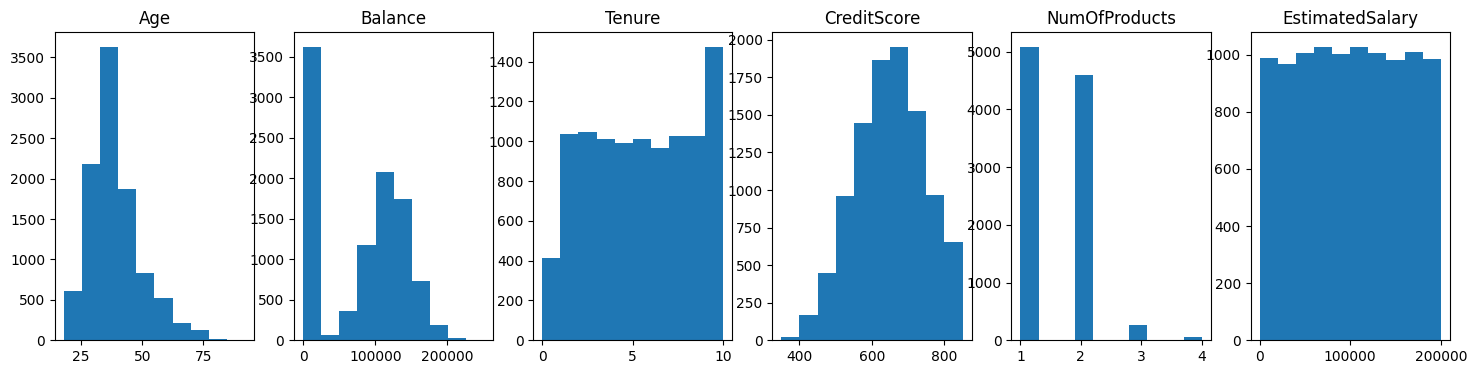

In [53]:
numerical_features = ["Age", "Balance", "Tenure", "CreditScore", "NumOfProducts", "EstimatedSalary"]
n = len(numerical_features)

def print_histograms(dataset):
  plt.figure(figsize=(18, 4))

  for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, n, i)
    plt.hist(dataset[feature])
    plt.title(feature)

  plt.show()

print_histograms(baseline_ds)

Как видно, диапазоны значений признаков значительно различаются, что может привести к тому, что один признак будет неосновательно иметь больший вес по сравнению с другими.

Для решения этой проблемы применим нормализацию данных, чтобы привести все признаки к общему масштабу и устранить такие несоответствия.

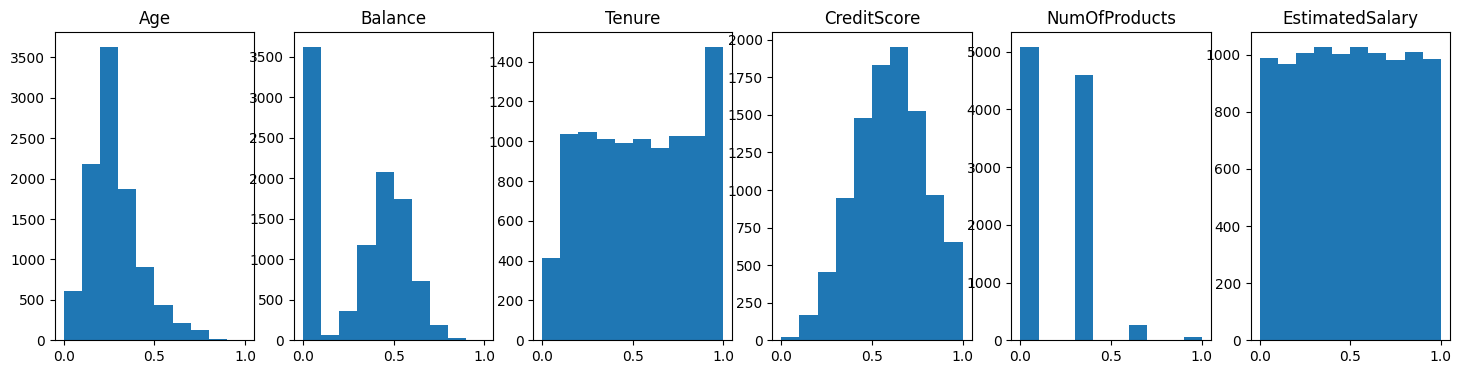

In [54]:

scaler = sklearn.preprocessing.MinMaxScaler()
optimized_ds = baseline_ds.copy()
optimized_ds[numerical_features] = scaler.fit_transform(optimized_ds[numerical_features])

print_histograms(optimized_ds)

In [55]:
(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds)

model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=4)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Accuracy: 0.8260
Precision: 0.6619
Recall: 0.2341
F1-Score: 0.3459

Confusion Matrix:
[[1560   47]
 [ 301   92]]


Показатели метрик улучшились - гипотеза верна.

### Подбор гиперпараметров  

Значения гиперпараметров, заданные по умолчанию, не всегда являются оптимальными для конкретного датасета.  

Поэтому бывает полезно подобрать более подходящие значения гиперпараметров, которые лучше всего соответствуют особенностям текущего набора данных.  

Для этого используем метод подбора гиперпараметров на основе алгоритма grid search.

In [56]:
param_grid = {
  "n_neighbors": [2, 3, 5, 7, 9, 12],
  "weights": ["uniform", "distance"],
  "metric": ["euclidean", "manhattan"],
}

(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds)
model = sklearn.neighbors.KNeighborsClassifier()
grid = sklearn.model_selection.GridSearchCV(model, param_grid, scoring="f1", cv=5)
grid.fit(X_train, y_train)

results = grid.cv_results_
best_score = grid.best_score_

# Вывод результатов

best_params = grid.best_params_
best_model = grid.best_estimator_

grid.fit(X_train, y_train)

print(f"Best Parameters: {best_params}")
print_model_metrics(best_model, X_test, y_test)

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}
Accuracy: 0.7935
Precision: 0.4727
Recall: 0.4402
F1-Score: 0.4559

Confusion Matrix:
[[1414  193]
 [ 220  173]]


Как видно, значение метрики "Accuracy" немного снизилось, но это компенсируется значительным улучшением метрики "F1-Score".  

Модель стала гораздо более устойчивой к несбалансированности данных. Также интересно, что увеличение числа соседей не привело к улучшению результатов, а наоборот — оптимальным оказалось меньшее количество соседей.

## 4. Имплементация алгоритма машинного обучения
Будем использовать реализованный ранее.

In [57]:
(X_train, y_train), (X_test, y_test) = generate_train_data(baseline_ds)

model = KNN(n_neighbors=4, task='classification')
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Accuracy: 0.7370
Precision: 0.2096
Recall: 0.1221
F1-Score: 0.1543

Confusion Matrix:
[[1426  181]
 [ 345   48]]


Результаты ухудшились незначительно.

In [60]:
(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds)
model = KNN(n_neighbors=4, task='classification')
model.fit(X_train, y_train)
print_model_metrics(model, X_test, y_test)


Accuracy: 0.8235
Precision: 0.5758
Recall: 0.3868
F1-Score: 0.4627

Confusion Matrix:
[[1495  112]
 [ 241  152]]


Здесь уже разница значительнее.